# Learning motor primitives on a small crawling robot using Q-Learning.


***

## Table of content:

* [Review of Q-learning](#1)
    * Algorithm
    * Behavior policy
* [Simulation](#2)
* [Heuristic improvement](#3)
    * Reward scaling
    * Action penalty
    * Q-value scaling
    * Warm-up period

* [Parameter optimisation](#4)
    * Bayesian optimisation
    * Result
    * Parameter performance
        * Greedy vs Boltzmann
        * Gamma
        * Alpha
    * Noise
    
* [Eligility traces](#5)
    * Overview
    * TD($\lambda$) and Naive Q($\lambda$)
    * Result

***

## Review of Q-learning <a id='1'></a>

### 1. Algorithm:
The main algorithm is define as:

$            Q(S_t,A_t) \leftarrow Q(S_t, A_t) + \alpha \left [ R_{t+1} + \gamma \max_a Q(S_{t+1},a) - Q(S_t,A_t) \right ]
$

The algorithm can be then implemented as follows: 

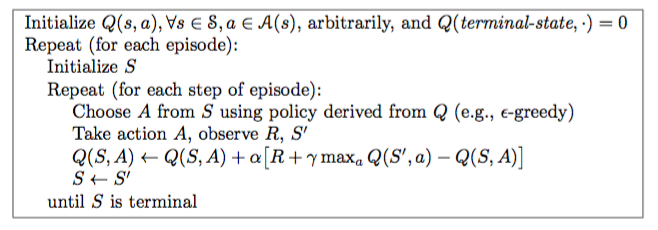

In [4]:
Image(filename="img/q-learning.png")

(Source: Reinforcement Learning - An Introduction.)

### 2. Behavior policy

As we have mentioned above, Q-learning is an **off-policy** learning method. The algorithm has 2 policies: one used to choose the next action in each time step, called *behavior policy*, and one whose value function we seek to learn, called the *target policy*. The choice of behavior policy is important as it is the main way to cope with the exploitation-exploration dilemma.
        
In this project, we have considered 2 types of behavior policy: $\epsilon$-greedy and the Boltzmann selection.

#### 2.1 $\epsilon$-greedy selection
When employing this strategy, the agent will usually follow the greedy rule, which means that it will chose the best action according to the state-action values. However, there is a small probability $\epsilon$ that, rather than take the best action, the agent will uniformly select an action from the remaining actions. 

#### 2.2 Boltzmann selection

With Boltzmann selection, the relative value of the state-action values is taken into account. By using a Softmax function, we "squash" the vector of state-action values into a vector of "probability", i.e it sums to 1. The action will be sampled from this vector with the corresponding probability.
            
Concretely, at a state **s**, an action **a** is selected with probability: 
            
$
                p = \frac{\exp(\frac{Q(s,a) - max_bQ(s,b)}{T})}{ \sum_{a} \exp(\frac{Q(s,a) - max_bQ(s,b)}{T})}
$            

**T** is called the temperature, and increases the exploration rate as it increases.
            
Later, in the parameter optimisation section, we will examine the difference in performance between these 2 policies.

***

## Simulation <a id='2'></a>

To analyse the performance of the algorithm, we have created a crawling robot simulation. The most important thing in this simulation is the reward table. The latter was created by observing and recording the wheel encoder data through many times. The reason that we had to give several try is because the data is quite noisy (this turned out to be a major problem when Q-learning was run on the robot).
    
In addition, we have made one important hypothesis: **the reward of an action between 2 states is reciprocal**: if the reward of an action going from state A to B is $x$, the reward of the action going from state B to A is $-x$. Theoretically, on a flat ground, this is logic: the inverse of the action which helps the robot move forward will make it move backward. However, in practice, we observed that this is not the case because of many factors, especially when the floor is slippery. The hypothesis is completely wrong when the robot is on a football field, where the grass leans in 1 direction.

Some modifications has been applied to the recorded reward table to satisfy this hypothesis.

In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 11,8

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [3]:
ideal_reward_table = [
    [ -250 , -15000, -405 , -15000],
    [-309 , -15000, -400 , 405  ],
    [-262 , -15000, -255 , 400  ],
    [-231 , -15000, -77  , 255  ],
    [-61  , -15000, 0    , 77   ],
    [0    , -15000, 0    , 0    ],
    [0    , -15000, -15000, 0    ],
    [-325 , 250  , -452 , -15000],
    [-270 , 309  , -325 , 452  ],
    [-200 , 262  , -190 , 325  ],
    [-125 , 231  , -10  , 190  ],
    [-2   , 61   , 0    , 10   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-192 , 325  , -390 , -15000],
    [-169 , 270  , -285 , -390 ],
    [-105 , 200  , -132 , 285  ],
    [-10  , 125  , -5   , 132  ],
    [0    , 2    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-117 , 192  , -350 , -15000],
    [-67  , 169  , -235 , 350  ],
    [-8   , 105  , -26  , 235  ],
    [0    , 10   , 0    , 26   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-38  , 117  , -250 , -15000],
    [0    , 67   , -148 , 250  ],
    [0    , 8    , -3   , 148  ],
    [0    , 0    , 0    , 3    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [0    , 38   , -195 , -15000],
    [0    , 0    , -193 , 195  ],
    [0    , 0    , -5   , 193  ],
    [0    , 0    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-15000, 0    , -255 , -15000],
    [-15000, 0    , -190 , 255  ],
    [-15000, 0    , -8   , 190  ],
    [-15000, 0    , 0    , 8   ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , -15000, 0    ]
]; 

In [4]:
real_reward_table = [
[2.23, -3500, -34.63, -3500],
 [-96.24, -3500, -170.29, 21.15],
 [-96.83, -3500, -84.52, 10.52],
 [-56.45, -3500, -155.32, 12.35],
 [-48.75, -3500, -88.44, -23.19],
 [0.64, -3500, 1.06, 1.37],
 [0.48, -3500, -3500, 0.44],
 [-47.35, -6.12, -134.48, -3500],
 [-108.4, -35.56, -179.94, 54.25],
 [-58.97, 17.74, -136.75, -23.34],
 [-135.78, 18.82, -62.87, -9.65],
 [0.12, 13.75, 0.91, 1.27],
 [1.37, 1.0, 0.52, 0.44],
 [1.06, 1.55, -3500, 0.79],
 [-118.62, -12.28, -221.75, -3500],
 [-138.0, 46.19, -197.95, -58.12], # 15
 [-101.0, 53.34, -45.42, -0.19],
 [-12.38, 6.59, -3.75, 13.11],
 [1.14, 1.97, 1.91, 6.75],
 [0.41, 0.23, 1.87, 0.14],
 [0.53, 0.25, -3500, 1.37],
 [-7.21, -86.5, -198.25, -3500],
 [-104.0, 11.31, -85.5, -29.5],
 [1.22, 26.44, -10.16, 23.0],
 [0.62, 6.62, 1.3, 5.42],
 [0.17, 1.31, 0.91, 0.95],
 [1.28, 1.02, 1.87, 0.83],
 [2.56, 1.22, -3500, 1.56],
 [-43.25, 8.83, -68.21, -3500],
 [-26.0, 4.12, -53.25, 48.38],
 [-3.5, -0.47, -24.81, 41.0],
 [1.31, 0.73, 0.4, 1.19],
 [1.55, 1.09, 0.39, 1.67],
 [0.52, 1.09, 1.11, 1.5],
 [1.0, 0.5, -3500, 1.03],
 [-9.47, 2.5, -44.91, -3500],
 [-37.5, -10.0, -105.89, 27.0],
 [-9.13, -15.44, 1.45, 36.62],
 [0.82, -0.4, 0.7, 1.0],
 [0.72, 0.86, 0.22, 1.72],
 [1.84, 0.87, 0.91, 0.81],
 [1.22, 0.84, -3500, 0.94],
 [-3500, -2.42, -54.56, -3500],
 [-3500, -16.28, -147.9, 55.0],
 [-3500, -20.75, -13.91, 55.31],
 [-3500, 1.66, 0.02, 0.12],
 [-3500, 0.75, 2.03, 0.66],
 [-3500, 0.94, 1.26, 0.69],
 [-3500, -0.33, -3500, -0.44]]

In [5]:
def Boltzmann_selection(learner, state):
    
    greedy_action = learner.qtable[state].argsort()[-1]

    numerator = np.exp((learner.qtable[state] - learner.qtable[state, greedy_action])/learner.T)
    
    action_proba_vector = numerator/np.sum(numerator)
    
    return action_proba_vector

def action_is_allowed(learner, state, action):

    if (action == 0 and not(state > learner.num_states - learner.servo_num_states - 1)):
        return True
    elif (action == 1 and not(state < learner.servo_num_states)):
        return True
    elif (action == 2 and not((state%learner.servo_num_states) == (learner.servo_num_states-1))):
        return True
    elif (action == 3 and not(state%learner.servo_num_states==0)):
        return True
    else:
        return False

In [6]:
class QLearner_zero(object):
    def __init__(self, 
                 servo_num_states, 
                 num_actions, 
                 alpha, 
                 gamma, 
                 random_action_rate,
                 random_action_decay_rate, 
                 warm_up_period, 
                 action_penalty,
                 initial_state,
                 scaling_point, 
                 scaling_factor,
                 T,
                 policy):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = random_action_rate
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = initial_state
        self.action = 0
        self.action_penalty = action_penalty
        self.qtable = np.zeros((self.num_states, self.num_actions))
        self.num_iteration = 0
        self.last_reward = 0
        self.scaling_point = scaling_point
        self.scaling_factor = scaling_factor
        self.T = T 
        self.policy = policy
        
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
    
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        state = self.state
        action = self.action
        qtable = self.qtable
        action_prime = -1

        greedy_action = self.qtable[state_prime].argsort()[-1]
    
        if self.policy == 'greedy': 
        
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
                action_prime = np.random.randint(0, self.num_actions)
            else:
                action_prime = greedy_action
                
            if self.num_iteration > self.warm_up_period: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
        
        elif self.policy == 'boltzmann': 
            
            action_proba_vector = Boltzmann_selection(self, state_prime)
        
            action_prime = np.random.choice(a=4, p=action_proba_vector)
            

        qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * qtable[state_prime, greedy_action] - qtable[state, action])

        self.state = state_prime
        self.action = action_prime    
        self.qtable = qtable

In [7]:
def get_final_reward(learner, reward_table, training_iteration):
    
    reward_list = []
            
    for iteration_step in xrange(training_iteration):      
            
        reward = reward_table[learner.state][learner.action] - learner.action_penalty

        next_state = learner.get_next_state()

        learner.move(next_state, reward)

        learner.num_iteration += 1 

        if learner.num_iteration % learner.scaling_point == 0: learner.qtable *= learner.scaling_factor

        reward_list.append(reward)
        
        
    return np.mean(reward_list)

***

## Heuristic improvement  <a id='3'></a>

During our project, this step was not actually planned before hand. We went straight to the optimisation process. However, the results were disappointing, either the agent took a lot of time to converge to the best sequences or it could not find it at all. 
    
It turned out that the scale and value of the reward is critical. We will now elaborate on the 4 "heuristics" that helped us accelerate the process.

### 1. Reward scaling 

We have an impression that when the agent does not receive enough positive reward, it struggles to find the best sequence. We tried many different approach to scale up/down the positive/negative rewards. Later we found out that it was not really necessary to do that, there is a much simpler solution: in the reward table, for the impossible pairs of state-action (like the one we mentioned above), instead of give them 0 reward, we assign them with a big negative number to prevent the robot from getting stuck there. After many trial and error, the "magical" number is -15000 for our case.

### 2. Action penalty
This is quite subtle as well, we want to encourage the robot to find the shortest, most beneficial sequence of action. In order to do that, a logical option is to impose a penalty for each action taken. The best value that we find is 50. 

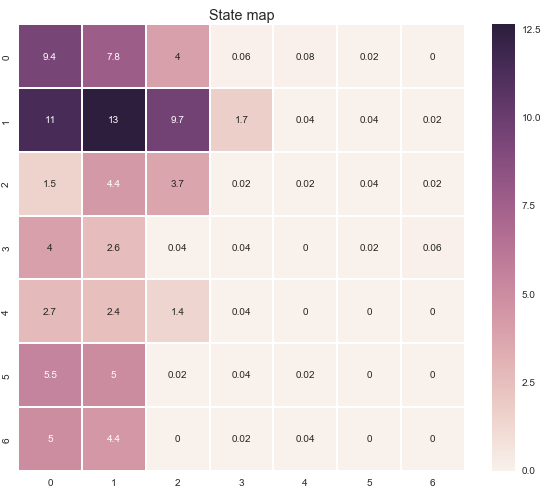

In [8]:
Image(filename="img/before_penal.png")

(Action penalty = 10, 5000 iterations, no convergence.)

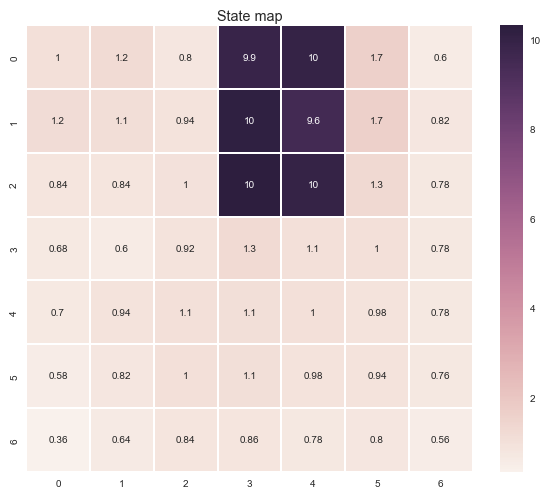

In [9]:
Image(filename="img/after_penal.png")

(Action penalty = 50, 5000 iterations, the best sequence is found.)

### 3. Q-value scaling

This heuristic is from an article by Soumi Ray and Tim Oates ([Locking in Returns: Speeding Up Q-Learning by Scaling](https://ewrl.files.wordpress.com/2011/08/ewrl2011_submission_7.pdf)). Their idea is simple: scaling the values in the Q-table after small amounts of learning. This method has shown some remarkable improvements in the convergence speed of our algorithm. It presents 2 additional parameters: the number of steps required before scaling and the scaling factor. They will go into the optimisation process along with other Q-learning parameters. 

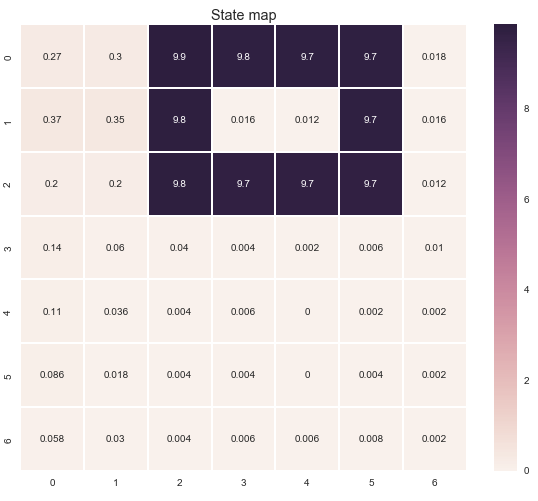

In [10]:
Image(filename="img/before_scale.png")

(Before Q-value scaling, 10000 iterations, stuck in a local minima.)


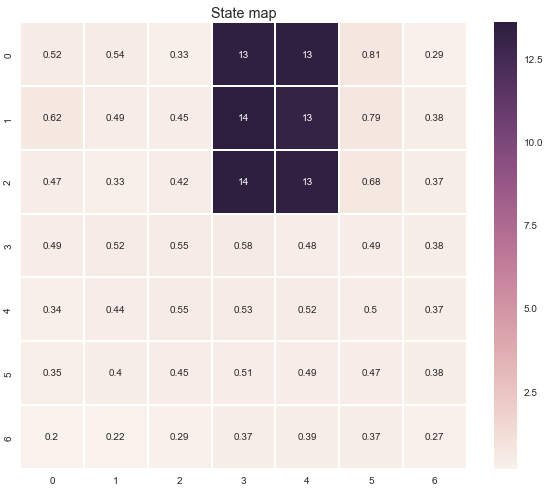

In [11]:
Image(filename="img/after_scale.png")

(After Q-value scaling, 10000 iterations, the best sequence is found.)

### 4. Warm-up period

This was mainly aimed to solve the mechanical problem: we want to reduce the "moving" time of the robot as much as possible because it is costly. Our strategy is to begin the Q-learning process with a "warm up" period with high random action rate where the robot's main mission is to explore the reward space and the action space. After this period, the random action rate will begin to decay and Q-learning will kick in.

The warm up period will also go into the optimisation process. 

***

## Parameter optimisation <a id='4'></a>

### 1. Bayesian optimisation

Parameter optimisation is usually considered as a "black art" in machine learning, especially when dealing with complex models as Deep Learning or Gradient Boosting. The classical approaches are grid search or random search: we hand pick some interval for our parameters, try different combinations and then choose the best one. The task is mundane and require some good intuitions in order to know where to look for. 
    
Recently, people begin to prefer the automatic optimisation method. The idea can be explained as below: imagine having an unknown, blackbox function $f$ that takes the machine learning parameters (for example a vector $x[x1,x2]$) as its parameters and returns a loss value. The goal is thus to find the $x$ where $f(x)$ is minimized.
    
One approach is to sample $x$ from its distribution, compute $f(x)$ and look for the minimum zone. The important constraint here is that we want to sample as efficiently as possible. In other words, we want to focus the searching process in the promising zone of the high dimensional parameters space and ignore the rest. This problem is classically known as the multi-armed bandit problem. It is the foundation of Bayesian optimisation with many important applications [(Google uses this for its A/B tests)](https://support.google.com/analytics/answer/2844870?hl=en).

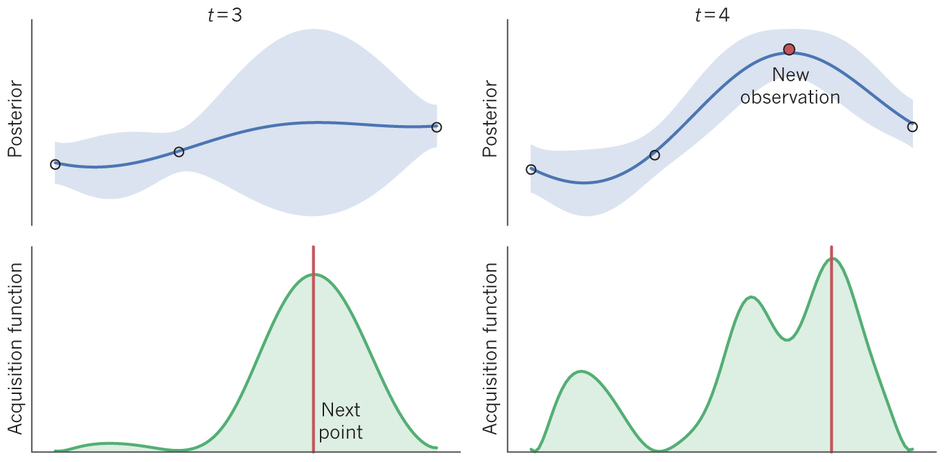

In [14]:
Image(filename="img/gp.jpg", width = 800, height=800)

(Gaussian Process, a popular Bayesian Optimisation method. We determine the next point to sample by using an acquisation function that model the probability of the zone containing the maxima.)

In this project we use [Hyperopt](http://hyperopt.github.io/hyperopt/) for the optimisation task. This package use a Bayesian technique called TPE (tree of Parzen estimators) to find the best parameter combination in order to minimize a pre-defined loss function (negative long-term reward in our case).
    
Depending on the behavior policy ($\epsilon$-greedy or Boltzmann), we have around 5-8 parameters to tune (alpha, gamma, random action rate, random action decay rate, temperature, scaling factor, ...) 

In [13]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
import datetime

best_score = np.inf

def score_Q_zero_boltzmann(params):
    
    global best_score    
    
    num_iteration = 3
    
    loss_vector = []
    
    for i in xrange(num_iteration):
        
        learner = QLearner_zero(servo_num_states = 7,
               num_actions=4,
               alpha=float(params['alpha']),
               gamma=float(params['gamma']),
               random_action_rate=1,#float(params['random_action_rate']),
               random_action_decay_rate=1,#float(params['random_action_decay_rate']),
               warm_up_period=1,#int(params['warm_up_period']),
               action_penalty=50,
               initial_state=24,
               scaling_point = int(params['scaling_point']),
               scaling_factor = float(params['scaling_factor']),
               T = float(params['T']),
               policy = 'boltzmann') 
        
        temp_loss = - get_final_reward(learner, ideal_reward_table, training_iteration = 50000) # negative because we want to minimize loss
        loss_vector.append(temp_loss)
        
    loss = np.mean(loss_vector)
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.6f}".format(-loss), 
        print params 
        print datetime.datetime.now().time()
        print
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize_Q_zero_boltzmann(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'scaling_point': hp.choice('scaling_point', np.arange(5,300, 5)),
             'scaling_factor': hp.uniform('scaling_factor', 1., 2.),
             'T': hp.uniform('T', 0.1, 10)
            }

    best = fmin(score_Q_zero_boltzmann, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [14]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
import datetime

best_score = np.inf

def score_Q_zero_greedy(params):
    
    global best_score    
    
    num_iteration = 3
    
    loss_vector = []
    
    for i in xrange(num_iteration):
        
        learner = QLearner_zero(servo_num_states = 7,
                               num_actions=4,
                               alpha=float(params['alpha']),
                               gamma=float(params['gamma']),
                               random_action_rate=float(params['random_action_rate']),
                               random_action_decay_rate=float(params['random_action_decay_rate']),
                               warm_up_period=int(params['warm_up_period']),
                               action_penalty=50,
                               initial_state=24,
                               scaling_point = int(params['scaling_point']),
                               scaling_factor = float(params['scaling_factor']),
                               T =1,
                               policy = 'greedy') 
        

        temp_loss = - get_final_reward(learner, ideal_reward_table, training_iteration = 50000) # negative because we want to minimize loss
        loss_vector.append(temp_loss)
        
    loss = np.mean(loss_vector)
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.6f}".format(-loss), 
        print params 
        print datetime.datetime.now().time()
        print
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize_Q_zero_greedy(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'random_action_rate': hp.uniform('random_action_rate', 0.8,1), 
             'random_action_decay_rate': hp.uniform('random_action_decay_rate', 0.1, 1),
             'warm_up_period': hp.choice('warm_up_period', np.arange(0, 300,25)),
             'scaling_point': hp.choice('scaling_point', np.arange(5, 250, 5)),
             'scaling_factor': hp.uniform('scaling_factor', 1., 2.),
            }

    best = fmin(score_Q_zero_greedy, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [15]:
%%time

#Trials object where the history of search will be stored
trials_greedy = Trials()

best_params_greedy = optimize_Q_zero_greedy(trials_greedy)

Searching... New best score: -54.983740 {'warm_up_period': 50, 'random_action_decay_rate': 0.33518678817539516, 'scaling_factor': 1.0534977711841584, 'alpha': 0.9661455251788577, 'scaling_point': 110, 'gamma': 0.6912286690925842, 'random_action_rate': 0.8629831546562271}
11:32:12.970574

Searching... New best score: -53.989513 {'warm_up_period': 0, 'random_action_decay_rate': 0.27207745728530053, 'scaling_factor': 1.1086361558747713, 'alpha': 0.6869057812762359, 'scaling_point': 130, 'gamma': 0.6265334609114307, 'random_action_rate': 0.8497945262441063}
11:32:18.471589

Searching... New best score: -37.014907 {'warm_up_period': 150, 'random_action_decay_rate': 0.3831614344937051, 'scaling_factor': 1.1491802093407208, 'alpha': 0.21888480145596825, 'scaling_point': 150, 'gamma': 0.9348256672128448, 'random_action_rate': 0.888170720927459}
11:32:22.072040

Searching... New best score: -31.791087 {'warm_up_period': 50, 'random_action_decay_rate': 0.24509662544899605, 'scaling_factor': 1.44

In [16]:
%%time

#Trials object where the history of search will be stored
trials_boltzmann = Trials()

best_params_boltzmann = optimize_Q_zero_boltzmann(trials_boltzmann)

Searching... New best score: -28.246167 {'scaling_factor': 1.0013799574336468, 'alpha': 0.7858087932521516, 'scaling_point': 10, 'gamma': 0.9842733060978685, 'T': 4.14318362111746}
11:40:40.780605

Searching... New best score: -27.126533 {'scaling_factor': 1.1430998660930012, 'alpha': 0.9015677289527378, 'scaling_point': 200, 'gamma': 0.9630982242078951, 'T': 0.9460769353403498}
11:46:01.148530

Searching... New best score: -26.125553 {'scaling_factor': 1.0898388892246555, 'alpha': 0.9193406864019542, 'scaling_point': 105, 'gamma': 0.9788815772133558, 'T': 3.754564673164202}
11:49:00.436509

------------------------
Done.
Best parameter setting: {'scaling_factor': 1.0898388892246555, 'alpha': 0.9193406864019542, 'scaling_point': 20, 'gamma': 0.9788815772133558, 'T': 3.754564673164202}
CPU times: user 25min 56s, sys: 9.02 s, total: 26min 5s
Wall time: 26min 13s


### 2. Result


After carefully calibrating every details in our algorithm, the simulation begins to converge at the best sequences after around 1500-2000 iterations. This is a huge improvement in comparison with the naive approach in the beginning, when we needed 50000 iterations to reach the same results. 
    
The biggest reason that made the convergence so slow was that at some point, the learning process was stuck in a local minimum, and it took a lot of time for the Q-table to accumulate enough reward to get it out of there.

In [23]:
def test_crawling(policy, params, reward_table, training_iteration = 50000, draw=False, verbalise=False):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    reward_list = []
    mean_reward_list = []
    
    learner = None
    
    if policy == 'greedy': 
        
        learner = QLearner_zero(servo_num_states = 7,
               num_actions=4,
               alpha=float(params['alpha']),
               gamma=float(params['gamma']),
               random_action_rate=float(params['random_action_rate']),
               random_action_decay_rate=float(params['random_action_decay_rate']),
               warm_up_period=int(params['warm_up_period']),
               action_penalty=50,
               initial_state=24,
               scaling_point = int(params['scaling_point']),
               scaling_factor = float(params['scaling_factor']),
               T =1,
               policy = 'greedy') 
        
    elif policy == 'boltzmann': 
        
        learner = QLearner_zero(servo_num_states = 7,
                   num_actions=4,
                   alpha=float(params['alpha']),
                   gamma=float(params['gamma']),
                   random_action_rate=1,
                   random_action_decay_rate=1, 
                   warm_up_period=1, 
                   action_penalty=50,
                   initial_state=24,
                   scaling_point = int(params['scaling_point']),
                   scaling_factor = float(params['scaling_factor']),
                   T = float(params['T']),
                   policy = 'boltzmann') 
    
    for iteration_step in xrange(training_iteration):
    
        state_vector[learner.state] += 1
        action_vector[learner.action] += 1 
    
        reward = reward_table[learner.state][learner.action] - learner.action_penalty
        
        reward_list.append(reward)
        mean_reward_list.append(np.mean(reward_list))
        
        
        next_state = learner.get_next_state()
        learner.move(next_state, reward)
        learner.num_iteration += 1 

        if learner.num_iteration % learner.scaling_point == 0: 
            learner.qtable *= learner.scaling_factor

        if verbalise: 
            if iteration_step > training_iteration-30:
                print learner.state, 
 
    if verbalise: 
        print "\nReward per action: ",np.mean(reward_list)

    if draw: 
        normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
        state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
        sns.heatmap(state_map, linewidths=1, annot=True)
        plt.title('State map')
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    return reward_list, mean_reward_list

10 3 4 11 18 17 10 3 4 11 18 17 10 3 4 11 18 17 10 3 4 11 18 17 10 3 4 11 18 
Reward per action:  -354.9875


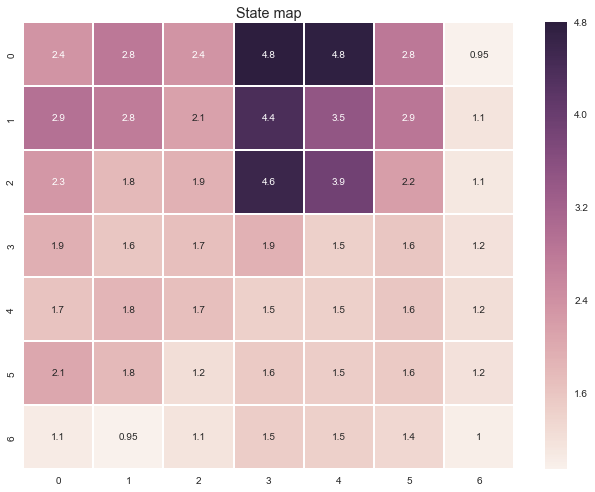

In [42]:
best_params_boltzmann = {'scaling_factor': 1.0898388892246555, 
                         'alpha': 0.9193406864019542, 
                         'scaling_point': 105, 
                         'gamma': 0.9788815772133558, 
                         'T': 3.754564673164202} # boltzmann 

reward_list_boltzmann, mean_reward_list_boltzmann = test_crawling(policy = 'boltzmann', 
                                                                  params = best_params_boltzmann, 
                                                                  reward_table = ideal_reward_table,
                                                                  training_iteration = 2000,
                                                                  draw = True,
                                                                  verbalise = True)

In the following section, we will analyse the effect of some primary parameter for the Q-learning algorithms. 

### 3. Parameter performance

#### 3.1 Greedy vs Boltzmann

In each mode, we run the optimisation process to find the optimal combination that maximize the mean reward per action after 50000 time steps.
        
The graph below shows the evolution of this value through time. We notice a sudden drop at the beginning of the learning process which correspond to the exploration phase then the algorithm begins to converge.
     

In [48]:
best_params_boltzmann = {'scaling_factor': 1.0898388892246555, 
                         'alpha': 0.9193406864019542, 
                         'scaling_point': 105, 
                         'gamma': 0.9788815772133558, 
                         'T': 3.754564673164202} # boltzmann 


best_params_greedy = {'warm_up_period': 75, 
                      'random_action_decay_rate': 0.6525737816885049, 
                      'scaling_factor': 1.0396254591439154, 
                      'alpha': 0.9909711092745332, 
                      'scaling_point': 150, 
                      'gamma': 0.9775990295203298, 
                      'random_action_rate': 0.8786583854998927} # lambda-greedy



reward_list_boltzmann, mean_reward_list_boltzmann = test_crawling(policy = 'boltzmann', 
                                                                  params = best_params_boltzmann,
                                                                  training_iteration = 10000,
                                                                  reward_table = ideal_reward_table)

reward_list_greedy, mean_reward_list_greedy = test_crawling(policy = 'greedy',
                                                            params = best_params_greedy, 
                                                            training_iteration = 10000,
                                                            reward_table = ideal_reward_table)

In [49]:
df_policy = pd.DataFrame({'greedy': mean_reward_list_greedy,
                          'boltzmann': mean_reward_list_boltzmann})
df_policy.head()

,boltzmann,greedy
0,-50.0,-50.0
1,-48.5,-50.0
2,-49.0,-50.0
3,-50.5,-50.0
4,-50.4,-50.0


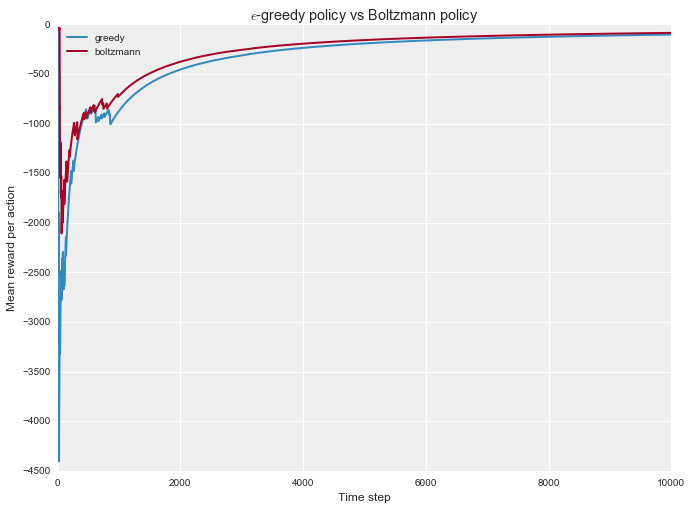

In [50]:
plt.plot(np.arange(len(mean_reward_list_greedy)), mean_reward_list_greedy, label='greedy')
plt.plot(np.arange(len(mean_reward_list_boltzmann)), mean_reward_list_boltzmann, label='boltzmann')
plt.legend(loc=2)
plt.title('$\epsilon$-greedy policy vs Boltzmann policy')
plt.xlabel('Time step')
plt.ylabel('Mean reward per action')
plt.show()

Boltzmann selection seems to be a better option here as its convergence speed is significantly higher than that of the $\epsilon$-greedy method.
        
For that reason, the experiments in the following sections are all made with agent using the Boltzmann policy.

#### 3.2 Gamma  

As we already know, Gamma $\gamma$ is a parameter that define the "patience", or "vision" of our robot. If $\gamma$ is closer to 0, the agent will tend to consider only immediate rewards.  If $\gamma$ is closer to 1, the agent will consider future rewards with greater weight, willing to delay the reward.    
        
In our case, the ideal $\gamma$ is 0.987, so we will examine the interval around this value, from 0.9 to 1 with a step size of 0.002.

In [53]:
def test_crawling_param_gamma(policy, params, gamma_list, reward_table, training_iteration = 50000):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    reward_list = []
    
    learner = None
    
    for gamma in gamma_list:
        
        temp_reward = []
    
        if policy == 'greedy': 

            learner = QLearner_zero(servo_num_states = 7,
                   num_actions=4,
                   alpha=float(params['alpha']),
                   gamma=gamma,
                   random_action_rate=float(params['random_action_rate']),
                   random_action_decay_rate=float(params['random_action_decay_rate']),
                   warm_up_period=int(params['warm_up_period']),
                   action_penalty=50,
                   initial_state=24,
                   scaling_point = int(params['scaling_point']),
                   scaling_factor = float(params['scaling_factor']),
                   T =1,
                   policy = 'greedy') 

        elif policy == 'boltzmann': 

            learner = QLearner_zero(servo_num_states = 7,
                       num_actions=4,
                       alpha=float(params['alpha']),
                       gamma=gamma,
                       random_action_rate=1,
                       random_action_decay_rate=1,
                       warm_up_period=1,
                       action_penalty=50,
                       initial_state=24,
                       scaling_point = int(params['scaling_point']),
                       scaling_factor = float(params['scaling_factor']),
                       T = float(params['T']),
                       policy = 'boltzmann') 

        for iteration_step in xrange(training_iteration):

            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 

            reward = reward_table[learner.state][learner.action] - learner.action_penalty

            temp_reward.append(reward)

            next_state = learner.get_next_state()
            learner.move(next_state, reward)
            learner.num_iteration += 1 

            if learner.num_iteration % learner.scaling_point == 0: 
                learner.qtable *= learner.scaling_factor

        reward_list.append(np.mean(temp_reward))

    
    return reward_list



best_params_boltzmann = {'scaling_factor': 1.2060122582747672, 
                         'alpha': 0.8035644279155065, 
                         'scaling_point': 235, 
                         'gamma': 0.9877568274011427, 
                         'T': 3.656564591173974} # boltzmann


gamma_list = np.arange(0.9,1.002,0.002)

reward_list_gamma = test_crawling_param_gamma(policy = 'boltzmann', 
                                              params = best_params_boltzmann, 
                                              gamma_list = gamma_list,
                                              reward_table = ideal_reward_table)


/Users/admin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


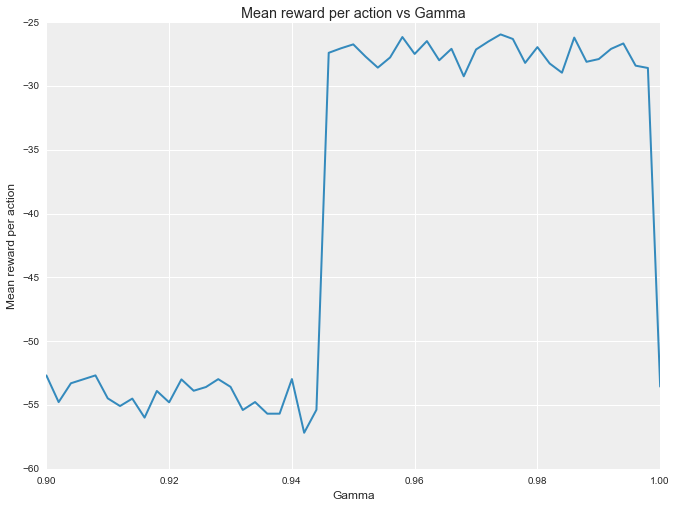

In [54]:
plt.plot(np.arange(0.9,1.002,0.002), reward_list_gamma)
plt.legend(loc=2)
plt.title('Mean reward per action vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Mean reward per action')
plt.show()

We observe that there is a small stable interval (from 0.958 to 0.996) in which the agent was able to converge to the best solution. 

#### 3.3 Alpha

Alpha $\alpha$ in the algorithm is a learning rate that controls how much of the difference between previous Q-value and newly proposed Q-value is taken into account. 
        
As before, we examine the interval surrounding the best $\alpha$ (0.919): 

In [57]:
def test_crawling_param_alpha(policy, params, alpha_list, reward_table, training_iteration = 50000):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    reward_list = []
    
    learner = None
    
    for alpha in alpha_list:
        
        temp_reward = []
    
        if policy == 'greedy': 

            learner = QLearner_zero(servo_num_states = 7,
                   num_actions=4,
                   alpha=alpha,
                   gamma=float(params['gamma']),
                   random_action_rate=float(params['random_action_rate']),
                   random_action_decay_rate=float(params['random_action_decay_rate']),
                   warm_up_period=int(params['warm_up_period']),
                   action_penalty=50,
                   initial_state=24,
                   scaling_point = int(params['scaling_point']),
                   scaling_factor = float(params['scaling_factor']),
                   T =1,
                   policy = 'greedy') 

        elif policy == 'boltzmann': 

            learner = QLearner_zero(servo_num_states = 7,
                       num_actions=4,
                       alpha=alpha,
                       gamma=float(params['alpha']),
                       random_action_rate=1,
                       random_action_decay_rate=1,
                       warm_up_period=1,
                       action_penalty=50,
                       initial_state=24,
                       scaling_point = int(params['scaling_point']),
                       scaling_factor = float(params['scaling_factor']),
                       T = float(params['T']),
                       policy = 'boltzmann') 

        for iteration_step in xrange(training_iteration):

            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 

            reward = reward_table[learner.state][learner.action] - learner.action_penalty

            temp_reward.append(reward)

            next_state = learner.get_next_state()
            learner.move(next_state, reward)
            learner.num_iteration += 1 

            if learner.num_iteration % learner.scaling_point == 0: 
                learner.qtable *= learner.scaling_factor

        reward_list.append(np.mean(temp_reward))

    
    return reward_list



best_params_boltzmann = {'scaling_factor': 1.2060122582747672, 
                         'alpha': 0.8035644279155065, 
                         'scaling_point': 235, 
                         'gamma': 0.9877568274011427, 
                         'T': 3.656564591173974} # boltzmann


alpha_list = np.arange(0.85, 1.005,0.004)

reward_list_alpha = test_crawling_param_alpha(policy = 'boltzmann', 
                                              params = best_params_boltzmann, 
                                              alpha_list = alpha_list,
                                              reward_table = ideal_reward_table)


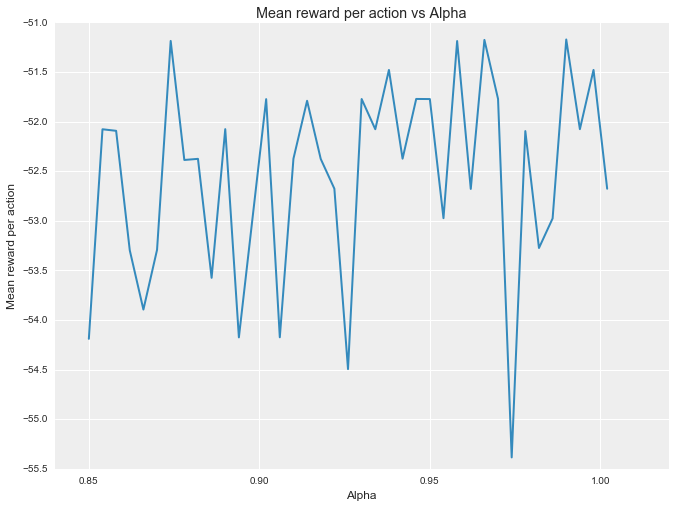

In [59]:
plt.plot(np.arange(0.85, 1.005,0.004), reward_list_alpha)
plt.legend(loc=2)
plt.title('Mean reward per action vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean reward per action')
plt.show()

In contrast to $\gamma$, here with $\alpha$ it does not seem to have any stable interval, the fluctuation is quite random and noisy.

***

## Eligiblity traces <a id='5'></a>

### 1. Overview

In Q-learning, the update in each time step is based on just the one next reward, using the values of the state one step later as a proxy for the remaining rewards. Monte Carlo, on the other hand, use an entire sequence of observed rewards from that state to the final state. It turns out that these 2 techniques are the 2 extremity of a more general family Temporal Difference method called $TD(\lambda)$ (Q-learning is $TD(0)$ and Monte Carlo is, as you can guess, $TD(1)$).

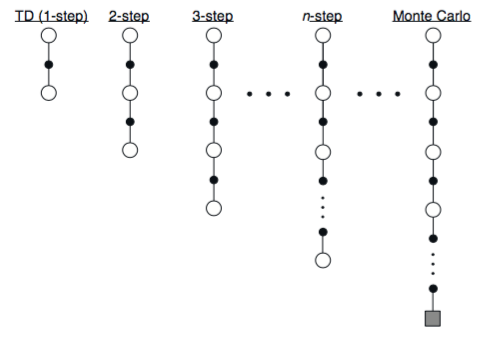

In [18]:
Image(filename="img/TD_lambda.png", width=600, height=600)

(The spectrum ranging from the one-step backups of simple TD methods to the up-until-termination backups of Monte Carlo methods. In between are the n-step back- ups, based on n steps of real rewards and the estimated value of the nth next state, all appropriately discounted. Source: *Reinforcement Learning - An Introduction*.)

This techniques allows us to update multiple states-actions that lead to the current reward, and thus accelerate the learning process.

### 2. TD($\lambda$) and naive Q($\lambda$)

For each state-action pair, a new value, the \textit{\textbf{eligibility trace}} is stored. This value increases whenever the state-action pair is seen, and decrements slowly at every other time step. The eligibility trace determines to what extend the state-action value is updated: states with high eligibility traces tend more towards the new information, whereas states with lower eligibility traces hardly change at all.

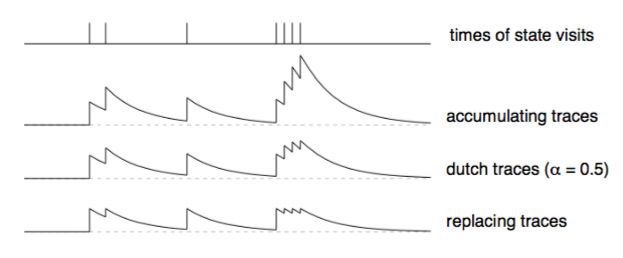

In [21]:
Image(filename="img/traces.png", width=700, height=700)

(The three different kinds of traces. Accumulating traces add up each time a state is visited, whereas replacing traces are reset to one, and dutch traces do something in-between. Source: *Reinforcement Learning - An Introduction*.)

 The first version of eligibility traces Q-learning was also proposed by Chris Watkins, the father of Q-learning. One problem with Q-learning is that it has 2 policies, and we want to keep track of the target policy. In Watkin's approach, the traces will be reset whenever it chooses a random action instead of the greedy one. 

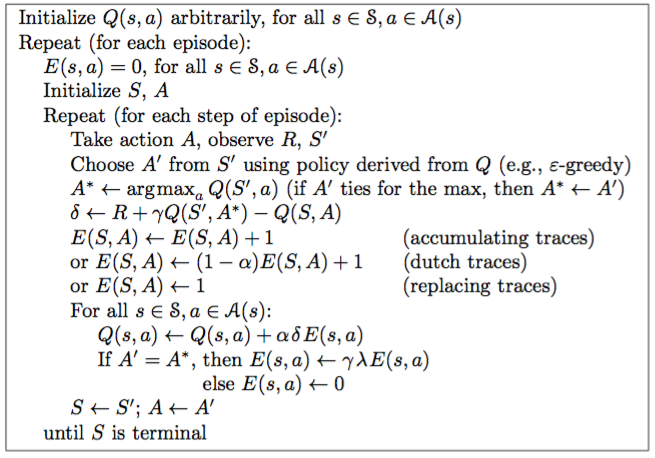

In [20]:
Image(filename="img/watkin.png", width=600, height=600)

(Source: *Reinforcement Learning - An Introduction*.)

However, cutting of traces every time an exploratory action is taken loses much of the advantage of using eligibility traces. If exploratory actions are frequent, as they often are early in learning, then only one or two steps are backup. 
    
McGovern and Sutton proposed an "naive" approach where instead of reset the traces, they also backup the exploratory actions. This approach seems to work well in preliminary empirical studies. 
    
In practice, the implementation of $TD(\lambda)$ has 1 issue: TD($\lambda$) is much more computational costly than the plain-vanilla Q-learning because at each time step we will update all the state-action values with their respective eligibility traces. One way to reduce computing time is to keep track of and update only the few states with nonzero traces. 
    
On the theoretical side, none of the methods are proven to converge.

### 3. Implementation and Result

In [60]:
class QLearner_lambda(object):
    def __init__(self, 
                 servo_num_states, 
                 num_actions, 
                 alpha, 
                 gamma, 
                 random_action_rate,
                 random_action_decay_rate, 
                 warm_up_period, 
                 action_penalty,
                 initial_state,
                 scaling_point, 
                 scaling_factor,
                 eligibility_lambda,
                 policy,
                 T):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = random_action_rate
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = initial_state
        self.action = 0
        self.action_penalty = action_penalty
        self.qtable = np.zeros((self.num_states, self.num_actions))
        self.num_iteration = 0
        self.last_reward = 0
        self.scaling_point = scaling_point
        self.scaling_factor = scaling_factor
        self.traces_table = np.zeros((self.num_states, self.num_actions))
        self.eligibility_lambda = eligibility_lambda
        self.T = T 
        self.policy = policy
        
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        eligibility_lambda = self.eligibility_lambda
        state = self.state
        action = self.action
        qtable = self.qtable
        traces_table = self.traces_table
        
            
        greedy_action = self.qtable[state_prime].argsort()[-1]
        
        action_prime = greedy_action
        
        if self.policy == 'greedy': 
        
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
                while action_prime == greedy_action: 
                    action_prime = np.random.randint(0, self.num_actions)
            
            else:
                action_prime = greedy_action # this is redundant, but we still left it here to be clear
                
            if self.num_iteration > self.warm_up_period: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
        
        elif self.policy == 'boltzmann': 
            
            action_proba_vector = Boltzmann_selection(self, state_prime)
        
            action_prime = np.random.choice(a=4, p=action_proba_vector)

            
        theta = reward + gamma * qtable[state_prime, greedy_action] - qtable[state, action]
        traces_table[state, action] = 1 
        
        for s in xrange(self.num_states):
            for a in xrange(self.num_actions):
                if traces_table[s,a] != 0:
                    qtable[s, a] = qtable[state, action] + alpha * theta * traces_table[s, a]
                    traces_table[s, a] = gamma * eligibility_lambda * traces_table[s, a]

        self.state = state_prime
        self.action = action_prime    
        self.qtable = qtable
        self.traces_table = traces_table

In [61]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
import datetime

best_score = np.inf

def score_Q_lambda(params):
    
    global best_score    
    
    num_iteration = 3
    
    loss_vector = []
    
    for i in xrange(num_iteration):
    
        learner = QLearner_lambda(servo_num_states = 7,
                               num_actions=4,
                               alpha=float(params['alpha']),
                               gamma=float(params['gamma']),
                               random_action_rate=1,
                               random_action_decay_rate=1,
                               warm_up_period=1,
                               action_penalty=50,
                               initial_state=24,
                               scaling_point = int(params['scaling_point']),
                               scaling_factor = float(params['scaling_factor']),
                               eligibility_lambda = float(params['eligibility_lambda']),
                               policy = 'boltzmann', 
                               T = float(params['T']))
    
        
        temp_loss = - get_final_reward(learner, reward_table, training_iteration = 50000) # negative because we want to minimize loss
        loss_vector.append(temp_loss)
        
    loss = np.mean(loss_vector)
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.6f}".format(-loss), 
        print params 
        print datetime.datetime.now().time()
        print
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize_Q_lambda(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'scaling_point': hp.choice('scaling_point', np.arange(5,300, 5)),
             'scaling_factor': hp.uniform('scaling_factor', 1., 2.),
             'eligibility_lambda': hp.choice('eligibility_lambda', np.arange(0.1,1,0.05)),
             'T': hp.choice('T', np.arange(0.1, 10, 0.1))
            }

    best = fmin(score_Q_lambda, space, algo=tpe.suggest, trials=trials, max_evals=150)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [ ]:
%%time

#Trials object where the history of search will be stored
trials_lambda = Trials()

best_params_lambda = optimize_Q_lambda(trials_lambda)

0 1 0 1 0 7 14 15 16 17 10 3 4 3 4 3 2 1 8 9 10 3 2 1 0 1 0 7 14 
Reward per action:  -750.90453


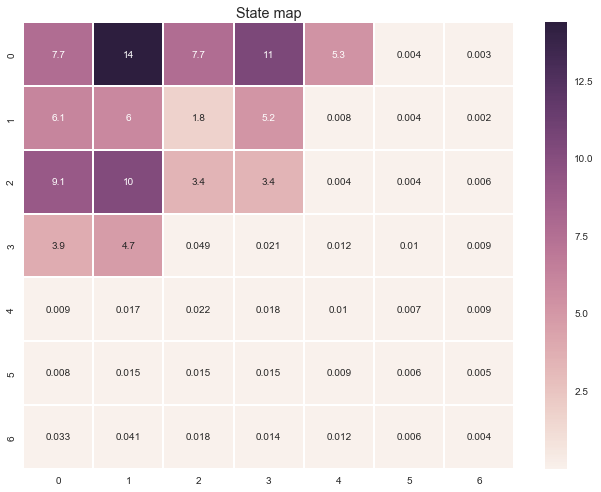

In [67]:
def test_crawling_Q_lambda(params, reward_table, training_iteration = 100000):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    temp_reward = []

    learner = QLearner_lambda(servo_num_states = 7,
                               num_actions=4,
                               alpha=float(params['alpha']),
                               gamma=float(params['gamma']),
                               random_action_rate=1,
                               random_action_decay_rate=1,
                               warm_up_period=1,
                               action_penalty=50,
                               initial_state=24,
                               scaling_point = int(params['scaling_point']),
                               scaling_factor = float(params['scaling_factor']),
                               eligibility_lambda = float(params['eligibility_lambda']),
                               policy = 'boltzmann', 
                               T = float(params['T']))

        
    for iteration_step in xrange(training_iteration):
    
        state_vector[learner.state] += 1
        action_vector[learner.action] += 1 
    
        reward = reward_table[learner.state][learner.action] - learner.action_penalty
        temp_reward.append(reward)

        next_state = learner.get_next_state()
        learner.move(next_state, reward)
        learner.num_iteration += 1 

        if learner.num_iteration % learner.scaling_point == 0: 
            learner.qtable *= learner.scaling_factor

        if iteration_step > training_iteration-30:
            print learner.state,
 
    
    print "\nReward per action: ",np.mean(temp_reward)

    
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map')
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.


best_params_lambda = {'eligibility_lambda': 0.40000000000000013, 
                      'T': 1.7000000000000002, 
                      'alpha': 0.517563113379945, 
                      'scaling_point': 25, 
                      'gamma': 0.2755235750455155, 
                      'scaling_factor': 1.523866043929635}
 

test_crawling_Q_lambda(best_params_lambda, ideal_reward_table)

Unfortunately, we still cannot get the Naive $Q(\lambda)$ to work properly. $\lambda$ was chosen from the optimisation process, along with other parameters. The algorithm doesn't seem to converge, even after 100000 iterations.
    
We are confident that our implementation is correct, so the problem might come from the scale of the reward/penalty and the parameters.
    
On a side note, in the Sutton's book, at the end of the chapter about Eligibility Traces, he said:
> By adjusting $\lambda$, we can place eligibility trace methods anywhere along a continuum from Monte Carlo to one-step TD methods. Where shall we place them? We do not yet have a good theoretical answer to this question, but a clear empirical answer appears to be emerging. On tasks with many steps per episode, or many steps within the half-life of discounting, it appears significantly better to use eligibility traces than not to. On the other hand, if the traces are so long as to produce a pure Monte Carlo method, or nearly so, then performance degrades sharply. Eligibility traces should be used to bring us toward Monte Carlo methods, but not all the way there. In the future it may be possible to vary the trade of between TD and Monte Carlo methods more finely by using variable  , but at present it is not clear how this can be done reliably and usefully.